# Differential Cell-cell communication with scSeqComm-CrossTalkeR

This notebook outlines the steps of inference, analysis and visualization of differential cell-cell communication for a single-cell RNA sequencing data using scSeqComm-CrossTalkeR.

The source code for CrossTalkeR is available on GitHub: [CostaLab/CrossTalkeR](https://github.com/CostaLab/CrossTalkeR) 

The source code for scSeqComm is available on Gitlab: [sysbiobig/scseqcomm](https://gitlab.com/sysbiobig/scseqcomm)

In [1]:
library(Seurat)
library(CrossTalkeR)
library(scSeqComm)
library(tidyverse)
library(data.table)
library(EnhancedVolcano)
require(ggplot2)

Attaching SeuratObject

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



Warning message:
“replacing previous import ‘dplyr::as_data_frame’ by ‘igraph::as_data_frame’ when loading ‘CrossTalkeR’”
Warning message:
“replacing previous import ‘dplyr::groups’ by ‘igraph::groups’ when loading ‘CrossTalkeR’”
Warning message:
“replacing previous import ‘clusterProfiler::simplify’ by ‘igraph::simplify’ when loading ‘CrossTalke

### Looking into the scRNAseq data

In the current tutorial, we will utilize the Myocardial Infarction data from [Kuppe 2022](https://www.nature.com/articles/s41586-022-05060-x), which comprises heart samples from 23 patients. From each sample, scRNAseq and SRT were obtained. For the interest of time, we focus our tutorial in studying only the Ishemic and Myogenic phenotypes

In [2]:
data <- readRDS("../../../../data_vt3/second/crosstalker/2306_scRNAseq_MOIZ.rds")

In [3]:
table(data$patient_group)


fibrotic ischemic myogenic 
       0    14961    95865 

## scSeqComm for each phenotype - only intercellular communication

In [4]:
myogenicmtx <- subset(data, patient_group=="myogenic") ## Subsetting the data for only myogenic cells
myogenicmeta <- data.frame(Cell_ID=colnames(myogenicmtx), Cluster_ID=myogenicmtx$cell_subtype2)

### Now we call scSeqComm function to perform the intercellular inference in the phenotypes we want to compare

In [5]:
data(LR_pairs_ConnectomeDB_2020) ## Selecting the LR resource
LR_db <- LR_pairs_ConnectomeDB_2020

In [6]:
num_core <- 8
res_myo <- scSeqComm_analyze(gene_expr = GetAssayData(myogenicmtx,'RNA'),
                                  cell_metadata = myogenicmeta,
                                  LR_pairs_DB = LR_db,
                                  inter_signaling = T,                      # wheter comppute intercellular signaling
                                  inter_scores = "scSeqComm",               # Intercellular signaling scoring schemes to be computed (default "scSeqComm")
                                  min_cells = 30,                           # Minimum number of cells that a cluster (i.e., cell type) should be composed of to compute scSeqComm score
                                  intra_signaling = F                      # whether compute intracellular signaling

                                  )

Check input data...


Cell type  prolif has only  0  cell. Removing it from the analysis...


**** scRNA-seq gene expression matrix having 

 - 27416 genes

 - 95865 cells

 - 32 cell groups/clusters (  Adipo  Arterial_Endo  CCL18_Macrophages  CD_4  CD_8  Capillary_Endo  Endocardial_Endo  Fib1_SCARA5  Fib2_Myofib  Fib3_C7  Fib4_COL15A1  LYVE_FOLR_Macrophages  LYVE_PLTP_Macrophages  Lymphatic_Endo  Mast  Monocytes  NK  NK_T  Neuronal  Pericyte_1  Pericyte_2  Purkinje_fibers  SPP1_Macrophages  Venous_Endo  damaged_CM  healthy_CM  intermediate_CM  perivascular_fibroblasts  vCM_3  vCM_4  vSMCs_1  vSMCs_2  )

Working with ... dgCMatrix


**** Ligand-receptor pair database having: 

 - 829 known ligands

 - 690 known receptors

 - 2293 known ligand-receptor pairs

**** Considering only ligands and receptors present in the input scRNA-seq data, the ligand-receptor pair database is reduced to: 

 - 668 known ligands

 - 632 known receptors

 - 1822 known ligand-receptor pairs


Analyzing inter

1.574 sec elapsed


**** Compute intercellular signaling evidence (i.e. ligand-receptor pair score S_inter)

 - Compute scSeqComm score



5.227 sec elapsed



Prepare output data...



In [7]:
rm(myogenicmtx) 
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8055704,430.3,14150921,755.8,14150921,755.8
Vcells,791544166,6039.1,2514433301,19183.7,1517179550,11575.2


### In analogous manner, we will infer the cell cell communication using the Ischemic samples

In [8]:
ischemicmtx <- subset(data, patient_group=="ischemic") ## Subsetting the data for only ischemic cells
ischemicmeta <- data.frame(Cell_ID=colnames(ischemicmtx), Cluster_ID=ischemicmtx$cell_subtype2)

In [9]:
res_isch <- scSeqComm_analyze(gene_expr = GetAssayData(ischemicmtx,'RNA'),
                                  cell_metadata = ischemicmeta,
                                  LR_pairs_DB = LR_db,
                                  inter_signaling = T,                      # wheter comppute intercellular signaling
                                  inter_scores = "scSeqComm",               # Intercellular signaling scoring schemes to be computed (default "scSeqComm")
                                  min_cells = 30,                           # Minimum number of cells that a cluster (i.e., cell type) should be composed of to compute scSeqComm score
                                  intra_signaling = F                      # whether compute intracellular signaling

                                  )

Check input data...


Cell type  Neuronal has only  0  cell. Removing it from the analysis...


Cell type  Purkinje_fibers has only  0  cell. Removing it from the analysis...


Cell type  prolif has only  0  cell. Removing it from the analysis...


**** scRNA-seq gene expression matrix having 

 - 27416 genes

 - 14961 cells

 - 30 cell groups/clusters (  Adipo  Arterial_Endo  CCL18_Macrophages  CD_4  CD_8  Capillary_Endo  Endocardial_Endo  Fib1_SCARA5  Fib2_Myofib  Fib3_C7  Fib4_COL15A1  LYVE_FOLR_Macrophages  LYVE_PLTP_Macrophages  Lymphatic_Endo  Mast  Monocytes  NK  NK_T  Pericyte_1  Pericyte_2  SPP1_Macrophages  Venous_Endo  damaged_CM  healthy_CM  intermediate_CM  perivascular_fibroblasts  vCM_3  vCM_4  vSMCs_1  vSMCs_2  )

Working with ... dgCMatrix


**** Ligand-receptor pair database having: 

 - 829 known ligands

 - 690 known receptors

 - 2293 known ligand-receptor pairs

**** Considering only ligands and receptors present in the input scRNA-seq data, the ligand-receptor pa

0.169 sec elapsed


**** Compute intercellular signaling evidence (i.e. ligand-receptor pair score S_inter)

 - Compute scSeqComm score



4.814 sec elapsed



Prepare output data...



In [10]:
rm(ischemicmtx) 
rm(data)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8035749,429.2,14150921,755.8,14150921,755.8
Vcells,61035159,465.7,2011546641,15346.9,1517179550,11575.2


### Following, we use a threshold to filter the relevant interactions

In [11]:
selected_comm_myo <- scSeqComm_select(res_myo$comm_results, 
                                  S_inter = 0.5,
                                  operator = "OR")
selected_comm_isc <- scSeqComm_select(res_isch$comm_results, 
                                  S_inter = 0.5,
                                  operator = "OR")

### Preparing the data for CrossTalkeR

In [12]:
selected_comm_myo<-selected_comm_myo %>%
    mutate(source=cluster_L) %>%
    mutate(target=cluster_R) %>%
    mutate(gene_A=ligand) %>%
    mutate(gene_B=receptor) %>%
    mutate(type_gene_A="Ligand") %>%
    mutate(type_gene_B="Receptor") %>%
    mutate(LRScore=round(S_inter,4)) %>%
    select(c("source", "target", "gene_A", "gene_B", "type_gene_A", "type_gene_B","LRScore"))%>%
    filter(!is.na(.data$LRScore)) %>% filter(.data$LRScore > 0.2)
selected_comm_isc<-selected_comm_isc %>%
    mutate(source=cluster_L) %>%
    mutate(target=cluster_R) %>%
    mutate(gene_A=ligand) %>%
    mutate(gene_B=receptor) %>%
    mutate(type_gene_A="Ligand") %>%
    mutate(type_gene_B="Receptor") %>%
    mutate(LRScore=round(S_inter,4))%>%
    select(c("source", "target", "gene_A", "gene_B", "type_gene_A", "type_gene_B","LRScore")) %>%
    filter(!is.na(.data$LRScore)) %>%
    filter(.data$LRScore > 0.2)

## CrossTalkeR

In [ ]:
paths <- list("myogenic"=selected_comm_myo, # control
             "ischemic"=selected_comm_isc) # experimental

ctkerdata<-generate_report(lrpaths = paths,
                threshold = 0,
                out_path = "/workspaces/ismb2025/cell-cell_communication/ismb-eccb-2025-tutorial-vt3/data_vt3/second/crosstalker/",
                out_file = "out.html",
                sel_columns = c("source", "target", "gene_A", "gene_B", "type_gene_A", "type_gene_B","LRScore"),filtered=TRUE)

Create a Differential Table

Adding missing grouping variables: `cellpair`
Adding missing grouping variables: `cellpair`
Calculating CCI Ranking

ischemic_x_myogenic



ischemic_x_myogenic_filtered



Calculating GCI Ranking

ischemic_x_myogenic

Annotating the top Cell Genes

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'sele

In [17]:
dir("../../../../data_vt3/second/crosstalker/")

[1] "2306_scRNAseq_MOIZ.rds"     "2306_scRNAseq_MOIZ.rds.dvc"
[3] "Comparative_out.html"       "LR_data_final.Rds"         
[5] "LR_data_step2.Rds"          "LR_data.Rds"               
[7] "Single_out.html"

### Looking into the differential abundant CCC pairs

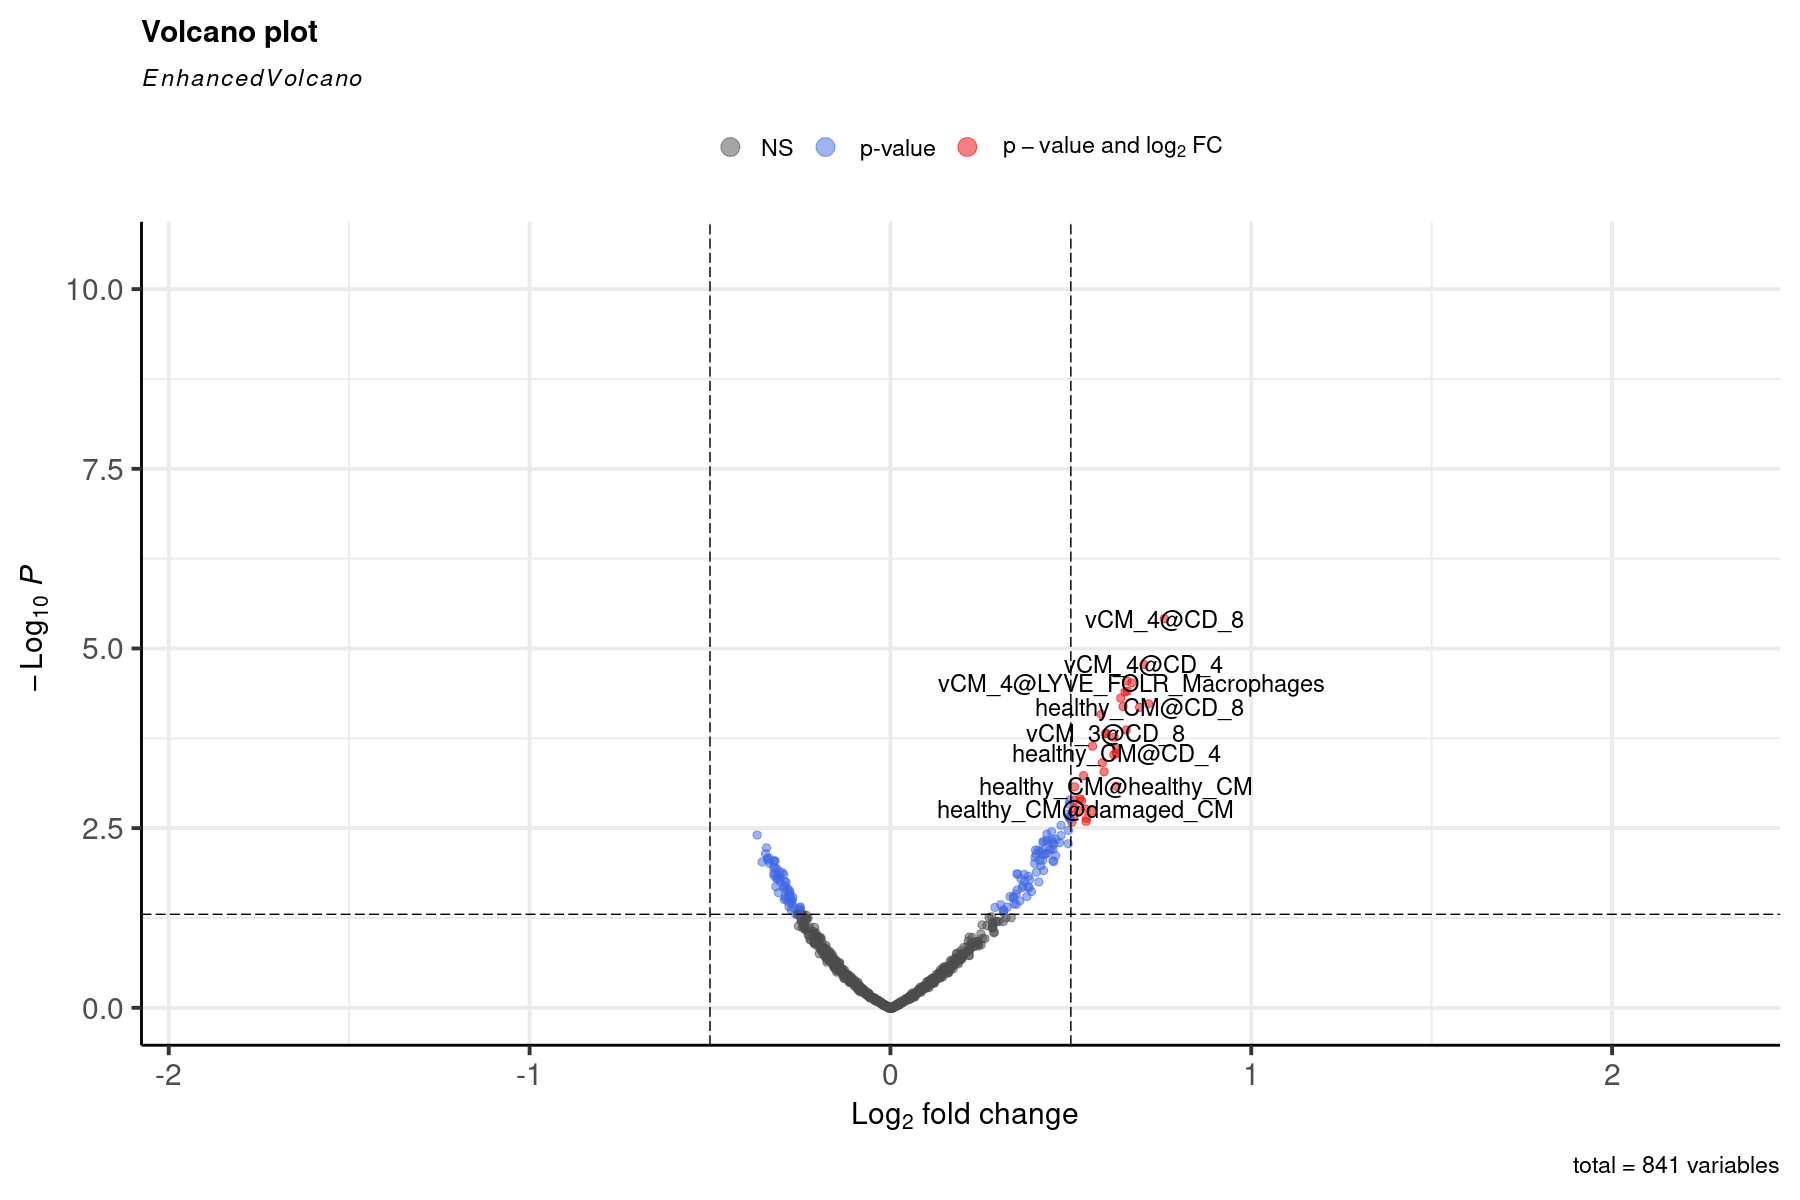

In [18]:
options(repr.plot.width=15,repr.plot.height=10)
EnhancedVolcano(ctkerdata@stats$ischemic_x_myogenic,
                lab = ctkerdata@stats$ischemic_x_myogenic$columns_name,
                x = "lodds",
                y = "p",
                pCutoff = 0.05,FCcutoff=0.5)

### Now we can use the filtered version to check which cells are communicating more and better

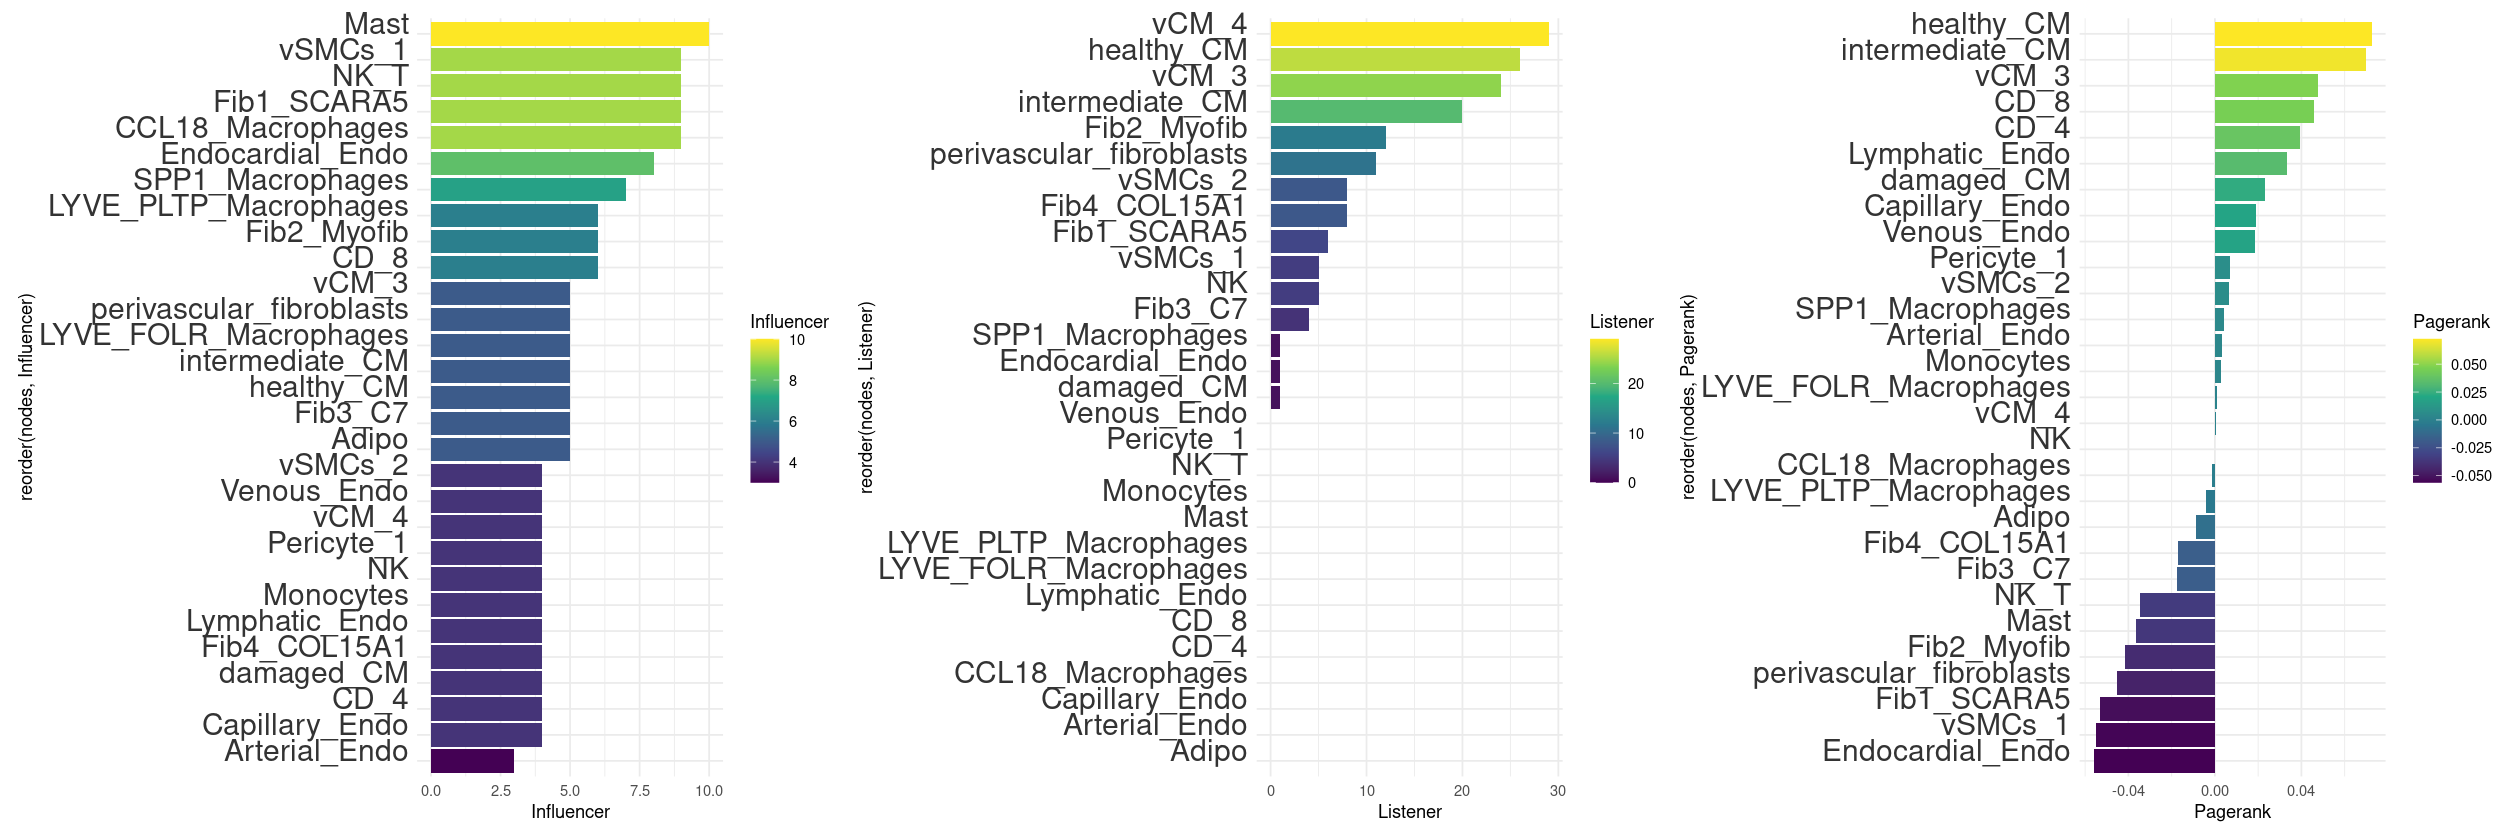

In [19]:
options(repr.plot.width=21,repr.plot.height=7)
p1<-ctkerdata@rankings$ischemic_x_myogenic_filtered |>
    ggplot(aes(x=Influencer,y=reorder(nodes,Influencer),fill=Influencer))+ 
          geom_bar(stat = "identity")+
          scale_fill_viridis_c()+
          theme_minimal()+
          theme(axis.text.y = element_text(color = "grey20", size = 18, angle = 0, hjust = 1, vjust = 0, face = "plain"))
p2<-ctkerdata@rankings$ischemic_x_myogenic_filtered |>
    ggplot(aes(x=Listener,y=reorder(nodes,Listener),fill=Listener))+ 
          geom_bar(stat = "identity")+
          scale_fill_viridis_c()+
          theme_minimal()+
          theme(axis.text.y = element_text(color = "grey20", size = 18, angle = 0, hjust = 1, vjust = 0, face = "plain"))
p3<-ctkerdata@rankings$ischemic_x_myogenic_filtered |>
    ggplot(aes(x=Pagerank,y=reorder(nodes,Pagerank),fill=Pagerank))+ 
          geom_bar(stat = "identity")+
          scale_fill_viridis_c()+
          theme_minimal()+
          theme(axis.text.y = element_text(color = "grey20", size = 18, angle = 0, hjust = 1, vjust = 0, face = "plain"))
p1+p2+p3

In [20]:
ctkerdata@tables$ischemic_x_myogenic %>%
    slice_max(order_by = -abs(LRScore),with_ties = FALSE,n=10)

LRScore,ligpair,recpair,allpair,type_gene_A,type_gene_B,gene_A,gene_B,source,target,cellpair,interaction_type
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
-1e-04,Adipo/ADAM17|L,LYVE_FOLR_Macrophages/ITGA5|R,Adipo/ADAM17|L@LYVE_FOLR_Macrophages/ITGA5|R,Ligand,Receptor,ADAM17|L,ITGA5|R,Adipo,LYVE_FOLR_Macrophages,Adipo@LYVE_FOLR_Macrophages,LR
-1e-04,Adipo/ADIPOQ|L,Fib4_COL15A1/ADIPOR2|R,Adipo/ADIPOQ|L@Fib4_COL15A1/ADIPOR2|R,Ligand,Receptor,ADIPOQ|L,ADIPOR2|R,Adipo,Fib4_COL15A1,Adipo@Fib4_COL15A1,LR
-1e-04,Adipo/APP|L,Adipo/TNFRSF21|R,Adipo/APP|L@Adipo/TNFRSF21|R,Ligand,Receptor,APP|L,TNFRSF21|R,Adipo,Adipo,Adipo@Adipo,LR
-1e-04,Adipo/B2M|L,NK/HLA-F|R,Adipo/B2M|L@NK/HLA-F|R,Ligand,Receptor,B2M|L,HLA-F|R,Adipo,NK,Adipo@NK,LR
-1e-04,Adipo/CD96|L,vCM_4/PVR|R,Adipo/CD96|L@vCM_4/PVR|R,Ligand,Receptor,CD96|L,PVR|R,Adipo,vCM_4,Adipo@vCM_4,LR
-1e-04,Adipo/CD99|L,perivascular_fibroblasts/PILRB|R,Adipo/CD99|L@perivascular_fibroblasts/PILRB|R,Ligand,Receptor,CD99|L,PILRB|R,Adipo,perivascular_fibroblasts,Adipo@perivascular_fibroblasts,LR
-1e-04,Adipo/COL1A2|L,Adipo/CD44|R,Adipo/COL1A2|L@Adipo/CD44|R,Ligand,Receptor,COL1A2|L,CD44|R,Adipo,Adipo,Adipo@Adipo,LR
-1e-04,Adipo/COL1A2|L,healthy_CM/ITGA11|R,Adipo/COL1A2|L@healthy_CM/ITGA11|R,Ligand,Receptor,COL1A2|L,ITGA11|R,Adipo,healthy_CM,Adipo@healthy_CM,LR
-1e-04,Adipo/COL1A2|L,LYVE_FOLR_Macrophages/CD93|R,Adipo/COL1A2|L@LYVE_FOLR_Macrophages/CD93|R,Ligand,Receptor,COL1A2|L,CD93|R,Adipo,LYVE_FOLR_Macrophages,Adipo@LYVE_FOLR_Macrophages,LR


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


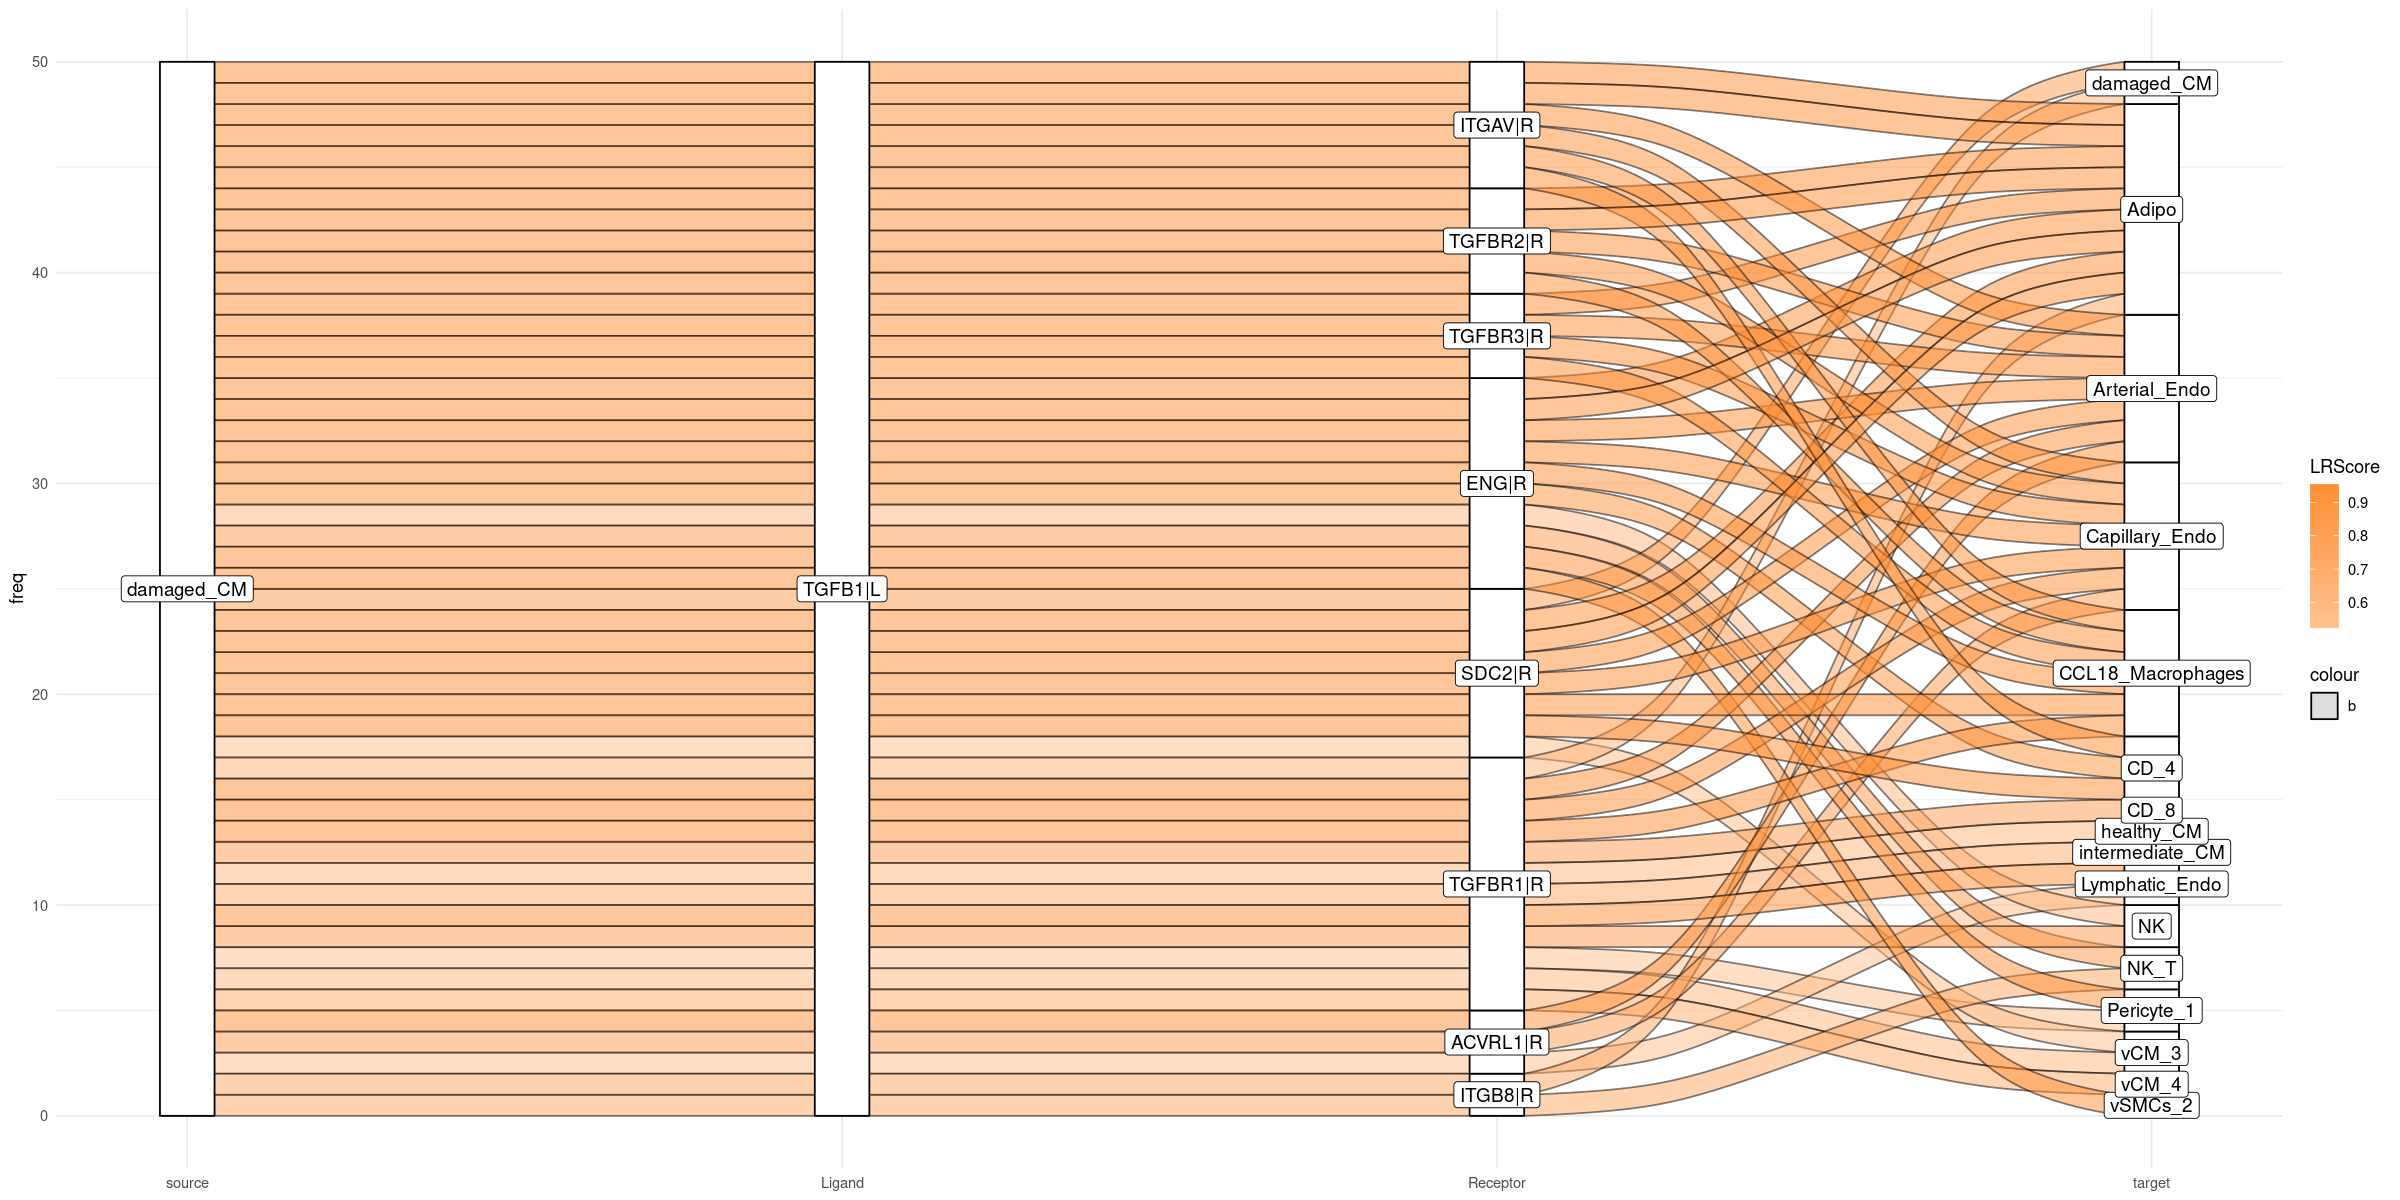

In [21]:
options(repr.plot.width=20,repr.plot.height=10)
threshold = 25
data <- ctkerdata@tables$ischemic_x_myogenic %>% 
        filter(source=="damaged_CM") %>%
        filter(gene_A == "TGFB1|L")
tmp_cols <- c("source", "Ligand", "Receptor", "target")
data$freq <-1
upsel <- dplyr::slice_max(data, order_by = data$LRScore,
                        n = ifelse(dim(data)[1] > threshold, threshold, dim(data)[1]), with_ties = FALSE)
lowsel <- dplyr::slice_min(data, order_by = data$LRScore,
                        n = ifelse(dim(data)[1] > threshold, threshold, dim(data)[1]), with_ties = FALSE)
tmp = rbind(upsel,lowsel)
ggplot2::ggplot(tmp, aes(y = .data$freq, axis1 = .data$source,
                               axis2 = stats::reorder(.data$gene_A, -.data$LRScore),
                               axis3 = stats::reorder(.data$gene_B, -.data$LRScore),
                               axis4 = .data$target)) +
        ggalluvial::geom_alluvium(aes(fill = .data$LRScore, color = 'b'),
                                  width = 1 / 12,
                                  discern = FALSE) +
        ggalluvial::geom_stratum(width = 1 / 12) +
        ggplot2::geom_label(stat = ggalluvial::StatStratum,
                            ggplot2::aes(label = ggplot2::after_stat(.data$stratum)),
                            size = 4) +
        ggplot2::scale_x_discrete(limits = tmp_cols, expand = c(.05, .05)) +
        ggplot2::scale_fill_gradient2(low = colorBlindness::Blue2DarkOrange18Steps[4],
                                      mid = colorBlindness::Blue2DarkOrange18Steps[10],
                                      high = colorBlindness::Blue2DarkOrange18Steps[14], midpoint = 0) +
        ggplot2::scale_color_manual(values = c("black")) +
        ggplot2::theme(text = element_text(size = 8)) +
        ggplot2::theme_minimal()
#ggsave("dCM_sankey.pdf",width=20,height=10)

In [22]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] knitr_1.44             colorBlindness_0.1.9   extrafont_0.19        
 [4] pals_1.8               graphlayouts_1.0.1     ggraph_2.1.0          
 [7] DT_